# Identify AR Events

In [572]:
%matplotlib ipympl

In [2]:
import ARUtils
import numpy as np
import pandas as pd
import xarray as xr
#import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

Load data from 1980 - 1989

In [4]:
ds = xr.open_dataset('ncfiles/b.e21.BHISTsmbb.f09_g17.LE2-1111.006.cam.h2.IVT.1980010100-1989123100.nc')

Select a single grid cell that covers Bodega Bay, CA (38.3332° N, 123.0481° W)

In [5]:
lat = 38.
lon = -123.125 + 360 
AR_THRESHOLD = 250.
ds_cell = ds.sel(lat=lat, lon=lon, method='nearest').IVT

Plot the IVT data for this cell 

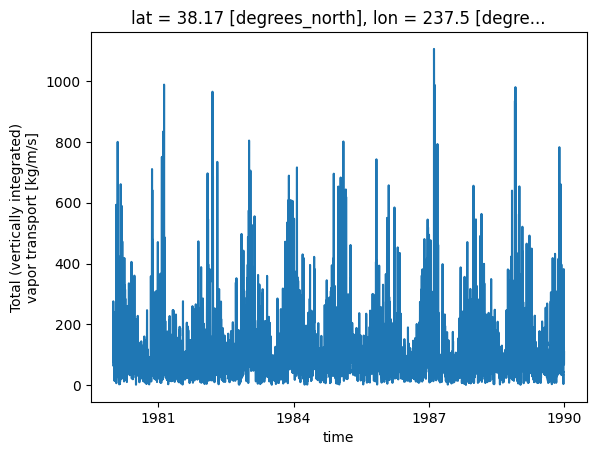

In [6]:
fig, ax = plt.subplots()
ds_cell.plot();

Plot all the IVT values above the 250 kg/m/s threshold.

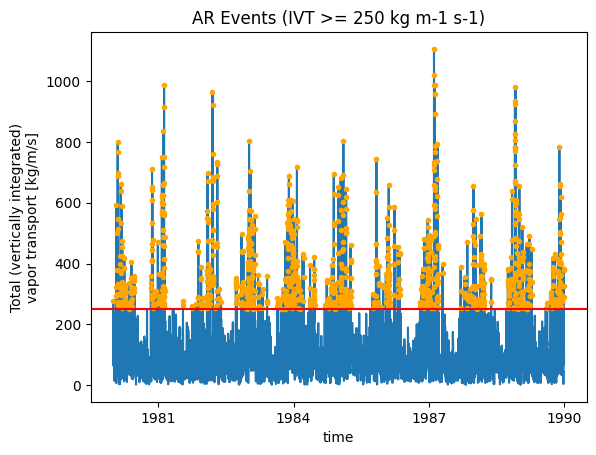

In [7]:
fig, ax = plt.subplots()
ds_cell.plot()
ds_cell.where((ds_cell >= AR_THRESHOLD)).plot(linestyle='', marker='.', color='orange')
ax.axhline(y=AR_THRESHOLD, color='red')
plt.title('AR Events (IVT >= 250 kg m-1 s-1)')
plt.show()

Categorize AR Events

In [8]:
# compute AR indices 
dat = ARUtils.create_ar_index_for_grid_cell(ds_cell.to_dataset())

# compute AR categories
dat = ARUtils.compute_ar_categories(dat)

Plot all AR Categories

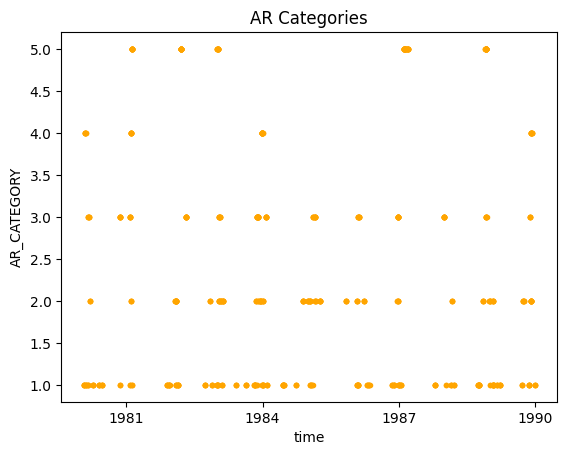

In [9]:
# plot AR Categories
fig, ax = plt.subplots()
dat.where(dat.AR_CATEGORY > 0).AR_CATEGORY.plot(linestyle='', marker='.', color='orange')
plt.title('AR Categories');

Plot all CAT-5 AR Events

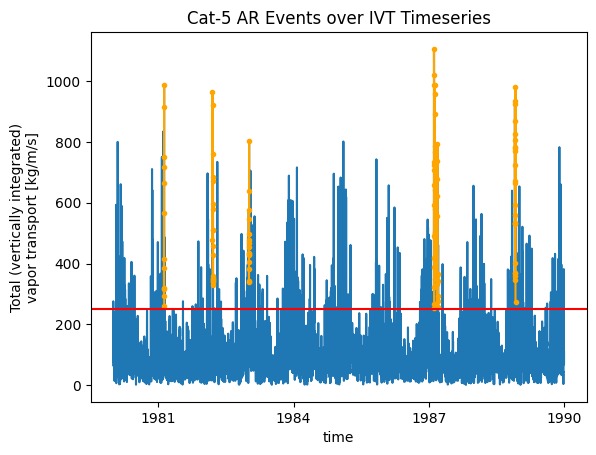

In [10]:
fig, ax = plt.subplots()
dat.IVT.plot()

dat5 = dat.where(dat.AR_CATEGORY == 5, drop=True)
for idx, dd in dat5.groupby(dat5.AR_INDEX):
        vals = dd.IVT.values
        if len(vals) > 1:
            dd.IVT.plot(linestyle='-', marker='.', color='orange')

ax.axhline(y=AR_THRESHOLD, color='red')
plt.title('Cat-5 AR Events over IVT Timeseries')
plt.show()

Plot AR category counts

/Users/castro/Documents/work/notebooks/data-processing/cesm2/conda-env/lib/python3.12/site-packages/xarray/core/dataset.py:4743: UserWarning: No index created for dimension AR_CATEGORY because variable AR_CATEGORY is not a coordinate. To create an index for AR_CATEGORY, please first call `.set_coords('AR_CATEGORY')` on this object.
  warnings.warn(


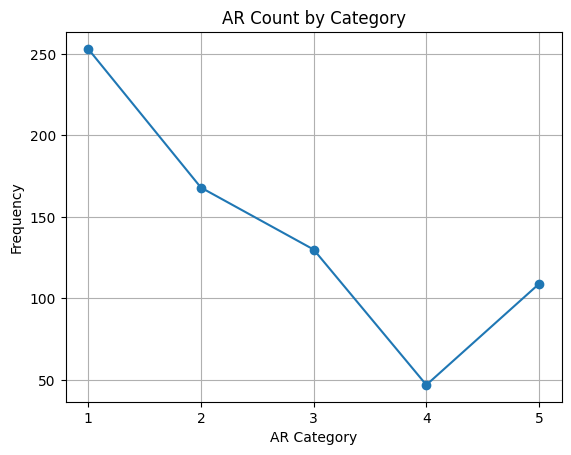

In [11]:
fig, ax = plt.subplots()
ARCount = dat.where(dat.AR_CATEGORY > 0, drop=True).groupby('AR_CATEGORY').count() 
plt.plot(ARCount.AR_CATEGORY, ARCount.AR_INDEX, marker='o')
plt.title('AR Count by Category')
plt.xlabel('AR Category')
plt.ylabel('Frequency')
plt.xticks([1, 2, 3, 4, 5])
plt.grid()
plt.show()


Create box plots for AR duration and AR IVT values

/var/folders/6l/9spwppmn3gxfld10q9_szx5h0000gp/T/ipykernel_22779/1649337703.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(


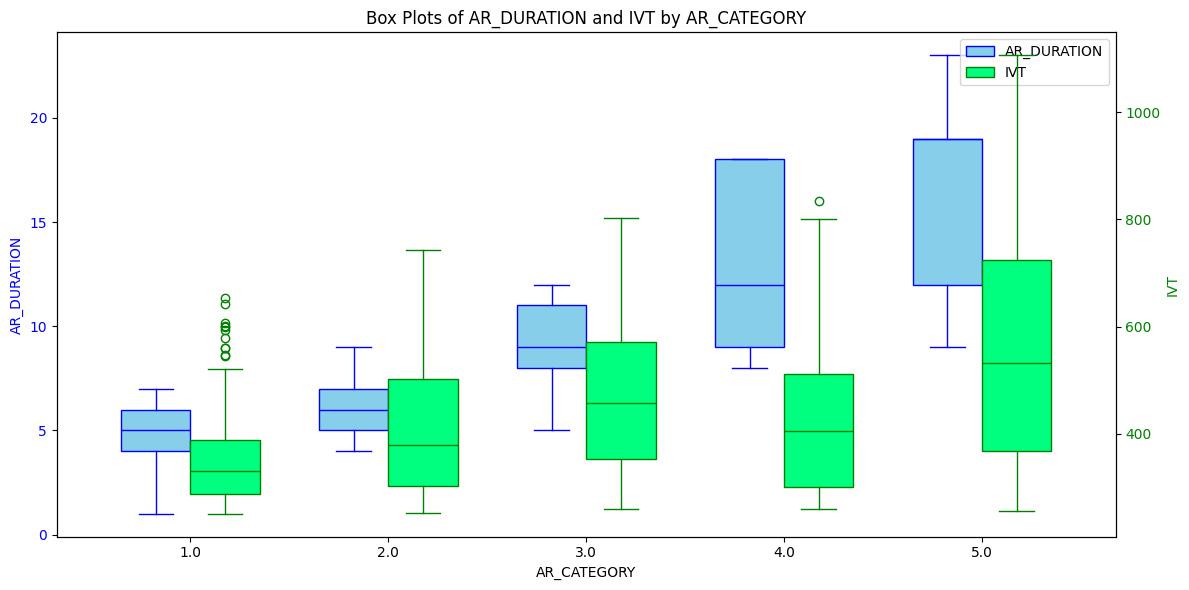

In [12]:
# convert dataset to dataframe 
df = dat.where(dat.AR_CATEGORY>0, drop=True).to_dataframe().reset_index()

# find unique categories
categories = df['AR_CATEGORY'].unique()
categories.sort()  # to make sure categories are in order

# Plots
fig, ax1 = plt.subplots(figsize=(12, 6))
positions = np.arange(len(categories))
width = 0.35  # box width

# boxplot for AR_DURATION
data_duration = [df[df['AR_CATEGORY'] == cat]['AR_DURATION'].dropna() for cat in categories]
bp1 = ax1.boxplot(
    data_duration,
    positions=positions - width/2,
    widths=width,
    patch_artist=True,
    boxprops=dict(facecolor='skyblue', color='blue'),
    medianprops=dict(color='blue'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    flierprops=dict(color='blue', markeredgecolor='blue'),
    labels=categories
)
ax1.set_ylabel('AR_DURATION', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# boxplot for IVT
ax2 = ax1.twinx()
data_ivt = [df[df['AR_CATEGORY'] == cat]['IVT'].dropna() for cat in categories]
bp2 = ax2.boxplot(
    data_ivt,
    positions=positions + width/2,
    widths=width,
    patch_artist=True,
    boxprops=dict(facecolor='springgreen', color='green'),
    medianprops=dict(color='green'),
    whiskerprops=dict(color='green'),
    capprops=dict(color='green'),
    flierprops=dict(color='green', markeredgecolor='green')
)
ax2.set_ylabel('IVT', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# settings
ax1.set_xticks(positions)
ax1.set_xticklabels(categories)
ax1.set_xlabel('AR_CATEGORY')
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='blue', label='AR_DURATION'),
    Patch(facecolor='springgreen', edgecolor='green', label='IVT')
]
ax1.legend(handles=legend_elements, loc='upper right')

plt.title('Box Plots of AR_DURATION and IVT by AR_CATEGORY')
plt.tight_layout()
plt.show()

How many AR category 5 events happened during 1980-1989? How long did each event last and what was the maximum IVT value during each event?

> If an AR_DURATION is 12, it means the event lasted for 12 6-hourly time steps, which is equal to 12*6/24=3 days.  

In [13]:
dat5['time'] = dat5.time.values.astype('datetime64[ns]')  # convert time to datetime64

df = dat5.to_dataframe().reset_index()  # convert to dataframe for easier manipulation

# ensure 'time' is in datetime64 format
df['time'] = pd.to_datetime(df['time'])

# group by AR_DURATION and find the start and end times for each event
result = df.groupby(['AR_DURATION', 'AR_INDEX']).agg(
    start_time=('time', 'min'),
    end_time=('time', 'max'),
    max_IVT=('IVT', 'max')
).reset_index()

# show only year-month-day
result['start_time'] = result['start_time'].dt.date
result['end_time'] = result['end_time'].dt.date

print(result)

   AR_DURATION  AR_INDEX  start_time    end_time      max_IVT
0          9.0     231.0  1987-02-11  1987-02-13  1106.199097
1         12.0      45.0  1981-02-15  1981-02-18   988.714661
2         12.0     234.0  1987-03-10  1987-03-13   793.244751
3         15.0      88.0  1983-01-03  1983-01-06   804.693848
4         19.0      66.0  1982-03-15  1982-03-20   965.395508
5         19.0     232.0  1987-02-15  1987-02-19   987.820618
6         23.0     280.0  1988-11-28  1988-12-03   980.407593


Calculate the probability of all AR categories during 1980-1989.

During 1980-1989, 799 AR conditions (IVT > 250 kg/m/s) were identified from the model outputs, 10% of which were classified as category 5 (exceptional condition). Overall, there were 5 events classified as category 5 (see results from the previous cell), occured in winter (Nov, Jan, and Feb). It is interesting that two out of these five events were in 1981 (Jan 22-25 and Feb 16-19) almost with the same intensity. Also, the 1986 and 1987 events hit this particular location at the same time of the year with almost the same IVT intensity. 

In [14]:
dat

<xarray.Dataset> Size: 526kB
Dimensions:      (time: 14600)
Coordinates:
    lat          float64 8B 38.17
    lon          float64 8B 237.5
  * time         (time) object 117kB 1980-01-01 00:00:00 ... 1989-12-31 18:00:00
Data variables:
    IVT          (time) float32 58kB 130.7 133.5 154.3 ... 67.99 84.58 108.8
    AR_INDEX     (time) float64 117kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    AR_DURATION  (time) float64 117kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    AR_CATEGORY  (time) float64 117kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [15]:
dat['time'] = dat.time.values.astype('datetime64[ns]')  

# convert to dataframe
df_all = dat.to_dataframe().reset_index()  

# set datetime64 format to `time` column
df_all['time'] = pd.to_datetime(df_all['time'])

# unique AR_INDEX count
print('Total number of AR events: ', df_all['AR_INDEX'].nunique())

Total number of AR events:  328


In [16]:
# calculate the count using groupby and agg()
prob = df_all[df_all.AR_CATEGORY > 0].groupby(['AR_CATEGORY']).agg(
    count=('AR_CATEGORY', 'count')
).reset_index()

In [18]:
prob

,AR_CATEGORY,count
0,1.0,253
1,2.0,168
2,3.0,130
3,4.0,47
4,5.0,109


In [19]:
prob.rename(columns={'count': 'AR_Condition'}, inplace=True)

# calculate the frequency as a separate step
prob['probability (%)'] = (prob['AR_Condition'] / df_all[df_all.AR_CATEGORY > 0].shape[0])*100

prob

,AR_CATEGORY,AR_Condition,probability (%)
0,1.0,253,35.785007
1,2.0,168,23.762376
2,3.0,130,18.387553
3,4.0,47,6.647808
4,5.0,109,15.417256


In [20]:
dat['time'] = dat.time.values.astype('datetime64[ns]')  

# convert to dataframe
df_all = dat.to_dataframe().reset_index()  

# set datetime64 format to `time` column
df_all['time'] = pd.to_datetime(df_all['time'])

# unique AR_INDEX count
print('Total number of AR events: ', df_all['AR_INDEX'].nunique())

# calculate the count using groupby and agg()
prob = df_all[df_all.AR_CATEGORY > 0].groupby(['AR_CATEGORY']).agg(
    count=('AR_CATEGORY', 'count')
).reset_index()

prob.rename(columns={'count': 'AR_Condition'}, inplace=True)

# calculate the frequency as a separate step
prob['probability (%)'] = (prob['AR_Condition'] / df_all[df_all.AR_CATEGORY > 0].shape[0])*100

prob

Total number of AR events:  328


,AR_CATEGORY,AR_Condition,probability (%)
0,1.0,253,35.785007
1,2.0,168,23.762376
2,3.0,130,18.387553
3,4.0,47,6.647808
4,5.0,109,15.417256


Add a regression or smoothed trend line to seperate events based on the combined impact of AR intensity and duration



In [24]:
df_all[90:100]

,time,lat,lon,IVT,AR_INDEX,AR_DURATION,AR_CATEGORY
90,1980-01-23 12:00:00,38.167539,237.5,106.746048,0.0,0.0,0.0
91,1980-01-23 18:00:00,38.167539,237.5,143.286789,0.0,0.0,0.0
92,1980-01-24 00:00:00,38.167539,237.5,167.281235,0.0,0.0,0.0
93,1980-01-24 06:00:00,38.167539,237.5,176.694519,0.0,0.0,0.0
94,1980-01-24 12:00:00,38.167539,237.5,202.987457,0.0,0.0,0.0
95,1980-01-24 18:00:00,38.167539,237.5,293.585876,2.0,3.0,1.0
96,1980-01-25 00:00:00,38.167539,237.5,593.313477,2.0,3.0,1.0
97,1980-01-25 06:00:00,38.167539,237.5,322.055603,2.0,3.0,1.0
98,1980-01-25 12:00:00,38.167539,237.5,39.806652,0.0,0.0,0.0
99,1980-01-25 18:00:00,38.167539,237.5,53.081383,0.0,0.0,0.0


In [25]:
# AR_DEGREE
#
# (at on cell)
# IVT * DUR * (6 * 3600)
# [..., 100, 150, 50, ...] * [..., 3, 3, 3, ...]
# [..., 300, 450, 150, ...] <= AR_DEGREE
#
# Sum AR_DEGREE for each AR_INDEX 
# OUTPUT => single value for each event, array size should be shape(max(AR_INDEX))
#


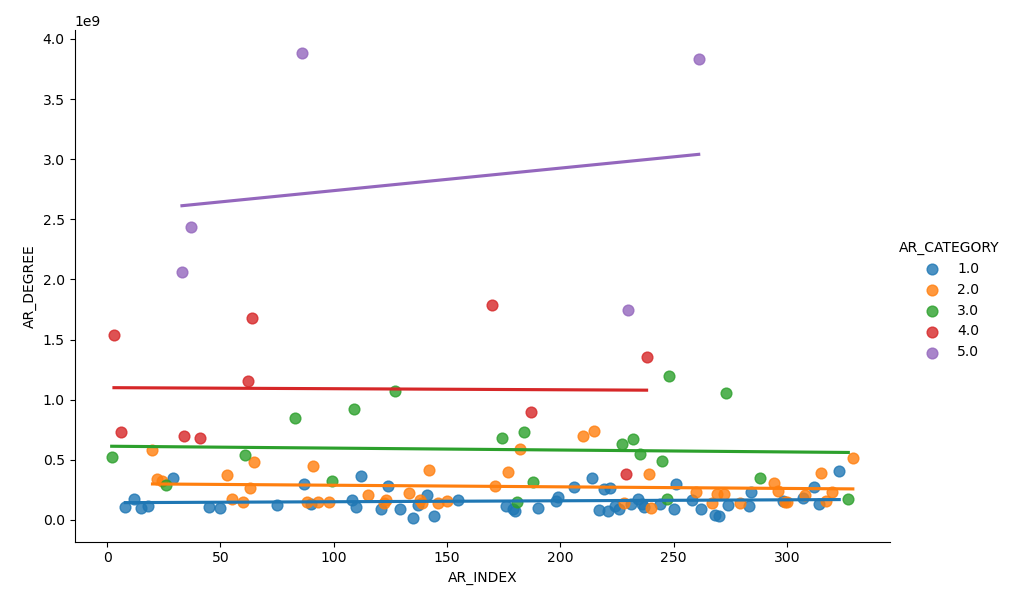

In [663]:
# calculate IVT in kg/m to combine both intensity and duration
df_all['IVT_kg/m'] = df_all['IVT']*df_all['AR_DURATION']*6*3600 # convert IVT to kg/m requires AR_DURATION in seconds

# calculate the total IVT for each AR event
df_all_cum = df_all.groupby('AR_INDEX').agg(
    AR_CATEGORY=('AR_CATEGORY', 'first'),
    AR_DURATION=('AR_DURATION', 'first'),
    IVT_max=('IVT', 'max'),
    AR_DEGREE=('IVT_kg/m', 'sum')  
).reset_index()

# Filter data for AR categories greater than 0
filtered_data = df_all_cum[df_all_cum['AR_CATEGORY'] > 0]

sns.lmplot(data=filtered_data, 
           x='AR_INDEX', 
           y='AR_DEGREE', 
           hue='AR_CATEGORY', 
           palette='tab10', 
           height=6, aspect=1.5, 
           scatter_kws={'s': 60},  
           ci=None)   
        
ax1.set_title('Cumulative IVT by AR Category with Min-Max Shaded Area')
ax1.set_xlabel('AR Index')
ax1.set_ylabel('AR DEGREE')
plt.show()

Compute exceedance probability.

In [664]:
# sort the dataset of AR events by cumulative IVT
filtered_data_sort = filtered_data.sort_values(by='AR_DEGREE', ascending=[False]).reset_index(drop=True)

# calculate rank and exceedance probability
filtered_data_sort['rank'] = filtered_data_sort.index + 1
filtered_data_sort['exceedance_probability'] = filtered_data_sort['rank']/filtered_data_sort.shape[0]

filtered_data_sort.head()

,AR_INDEX,AR_CATEGORY,AR_DURATION,IVT_max,AR_DEGREE,rank,exceedance_probability
0,86.0,5.0,20.0,817.942017,3.879319e+09,1,0.007576
1,261.0,5.0,20.0,695.530334,3.836731e+09,2,0.015152
2,37.0,5.0,15.0,1033.386719,2.439957e+09,3,0.022727
3,33.0,5.0,12.0,1173.024170,2.061695e+09,4,0.030303
4,170.0,4.0,14.0,657.584961,1.788898e+09,5,0.037879


Use a linear interpolation to calculate the chance of having an AR event with a cumulative IVT greater than a threshod (e.g., 1749581229 kg/m which is the minimum cumulative IVT from the AR category 5 in our dataset). There is about 5 percent chance of having such an event, which is identified as category 5 with the max IVT of kg/m/s for a period of 3 (12*6/24) days. 

In [665]:
# The chance of having an AR event with a cumulative IVT greater than a certain threshold
threshold = 1749581229  # the minimum AR_DEGREE for category 5 AR events. Reminder: AR_DEGREE is computed based on cumulative IVT times AR_DURATION*6*3600 (kg/m)

def interpolate_value(df, threshold):
    # sort by the column where the threonld is being applied
    df_sorted = df.sort_values(by='AR_DEGREE')

    # linear interpolation for the given threshold
    interpolated_value = np.interp(threshold, df_sorted['AR_DEGREE'], df_sorted['exceedance_probability'])

    # find the event associated with the threshold
    event = df_sorted[df_sorted['AR_DEGREE'] >= threshold].iloc[0]

    return interpolated_value, event

interpolate_value(filtered_data_sort, threshold)

(0.04545454547589763,
 AR_INDEX                  2.300000e+02
 AR_CATEGORY               5.000000e+00
 AR_DURATION               1.200000e+01
 IVT_max                   7.558635e+02
 AR_DEGREE                 1.749581e+09
 rank                      6.000000e+00
 exceedance_probability    4.545455e-02
 Name: 5, dtype: float64)

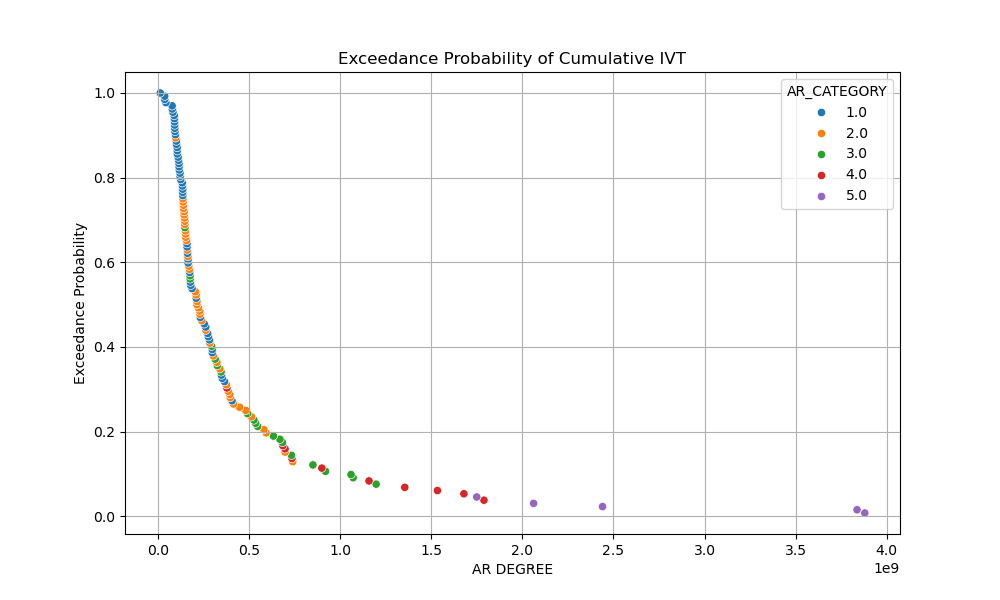

In [669]:
# Plot the exceedance probability
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_data_sort, 
                x='AR_DEGREE', 
                y='exceedance_probability', 
                marker='o', 
                hue='AR_CATEGORY', 
                palette='tab10')

plt.title('Exceedance Probability of Cumulative IVT')
plt.xlabel('AR DEGREE')
plt.ylabel('Exceedance Probability')
plt.grid()
plt.show()


In [657]:
# Describe the exceedance probability for category 5 AR events
filtered_data_sort[filtered_data_sort['AR_CATEGORY'] == 5]['exceedance_probability'].describe()

count    5.000000
mean     0.024242
std      0.014572
min      0.007576
25%      0.015152
50%      0.022727
75%      0.030303
max      0.045455
Name: exceedance_probability, dtype: float64